In [1]:
import pandas as pd
import numpy as np

In [2]:
full_train_df = pd.read_csv('data/train.csv', sep=";")
full_test_df = pd.read_csv('data/test.csv', sep=";")

In [4]:
from bs4 import BeautifulSoup

def preprocess_text(txt):
    res = BeautifulSoup(txt).text
    for char in ":;,.!?-\n\t":
        res = res.replace(char, " ")
    return res.lower()

In [5]:
txt_tr = full_train_df.text.map(preprocess_text).values
txt_te = full_test_df.text.map(preprocess_text).values
y_tr = full_train_df.target.values

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

probs_svc = np.zeros((len(txt_te), 6))

for vectorizer in [
    TfidfVectorizer(ngram_range=(1,1), smooth_idf=False, sublinear_tf=True), 
    TfidfVectorizer(ngram_range=(1,2), smooth_idf=False, sublinear_tf=True)
]:
    X_tr = vectorizer.fit_transform(txt_tr)
    X_te = vectorizer.transform(txt_te)

    model = LinearSVC(C=1.2, loss="hinge")
    model.fit(X_tr, y_tr)
    probs_svc += model.decision_function(X_te)

preds = np.argmax(probs_svc, axis=1)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [13]:
pd.DataFrame({"id":full_test_df.id.values, "target":preds})

id  target
0      31063       3
1      31064       2
2      31065       5
3      31066       4
4      31067       3
...      ...     ...
31059  62122       5
31060  62123       1
31061  62124       0
31062  62125       4
31063  62126       5

[31064 rows x 2 columns]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [9]:
cv = CountVectorizer()
X = cv.fit_transform(txt_tr)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_tr, test_size=0.33, random_state=42)

In [11]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [12]:
ovr = OneVsRestClassifier(LogisticRegression(penalty='l1'))

In [13]:
predict = ovr.fit(X_train, y_train).predict(X_test)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

In [15]:
accuracy_score(predict, y_test)

0.9288849868305531

<img src="https://miro.medium.com/max/1948/1*JqzG5_K4fWLa-_VFswQbxQ.png" alt="Drawing" style="height: 300px;"/>
<img src="https://miro.medium.com/max/1182/1*qKJwsZ3pdcua0k4U8IumVg.png" alt="Drawing" style="height: 300px;"/>
https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

In [16]:
f1_score(y_test, predict, average='macro')

0.9301739169243617

In [17]:
f1_score(y_test, predict, average='micro')

0.9288849868305531

In [18]:
predict = ovr.fit(X_train, y_train).predict_proba(X_test)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
log_loss(y_test, predict)

0.2823314763990899

<img src="https://miro.medium.com/max/1162/0*i2_eUc_t8A1EJObd.png" alt="Drawing" style="height: 300px;"/>

In [20]:
ovo = OneVsOneClassifier(LogisticRegression(penalty='l1'))

In [21]:
ovr.fit(X_train, y_train)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [22]:
l = []
for i in ovr.estimators_:
    l.append(i.predict_proba(X_test)[:,1])

In [23]:
result = np.stack(l, axis=0)

In [37]:
import umap.umap_ as umap
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='correlation').fit_transform(result.T)

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
sns.scatterplot(
    embedding[:,0],
    embedding[:,1], 
    hue=y_test,
    palette=sns.palettes.color_palette('dark', 6)
)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/envs/made_env_py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../

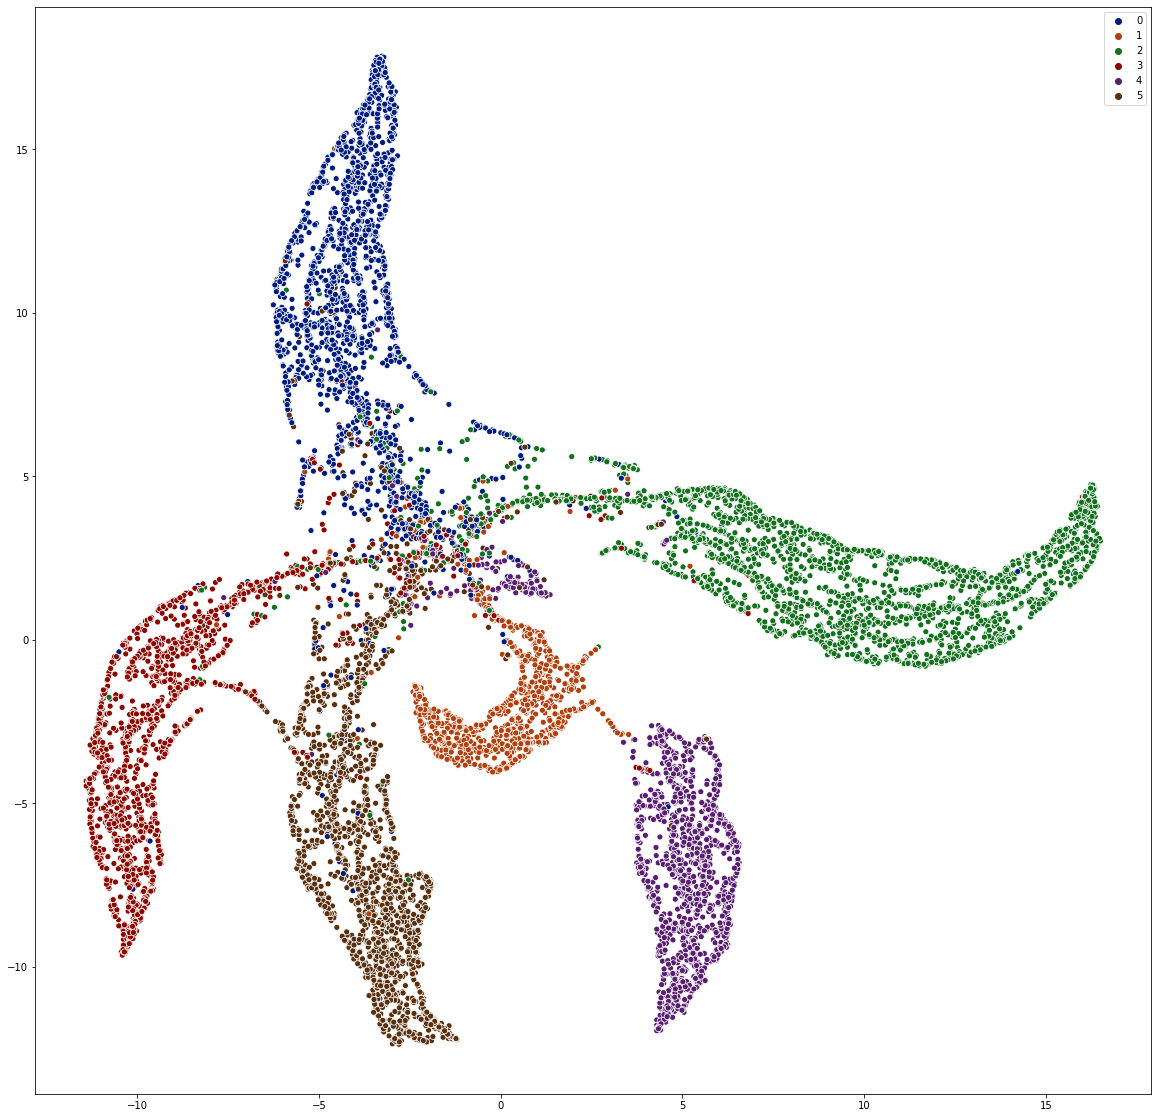

In [34]:
#import umap
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='euclidean').fit_transform(result.T)

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
sns.scatterplot(
    embedding[:,0],
    embedding[:,1], 
    hue=y_test,
    palette=sns.palettes.color_palette('dark', 6)
)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/envs/made_env_py36/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


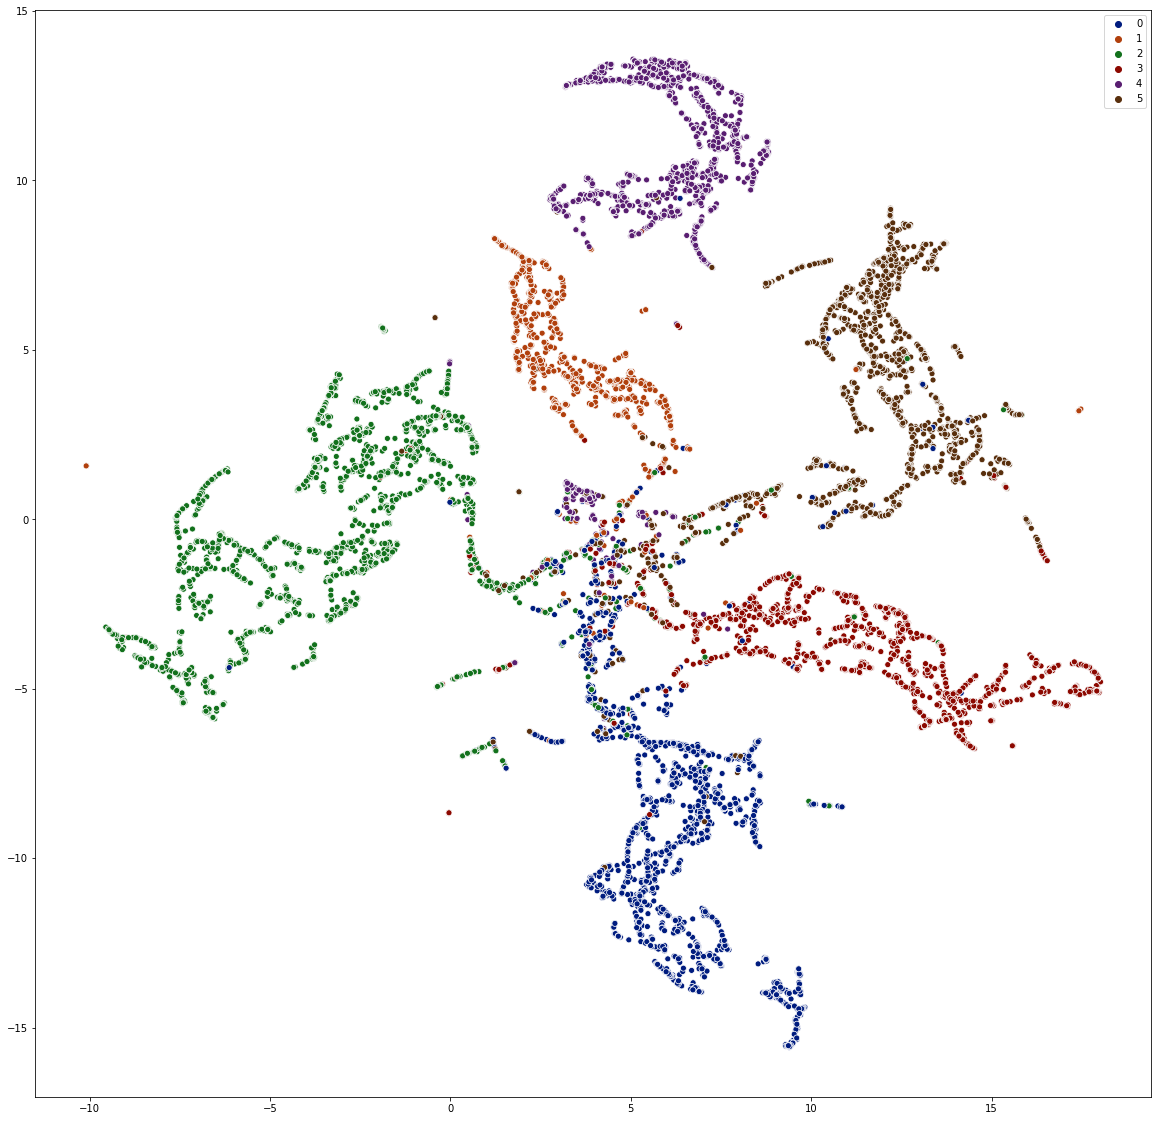

In [38]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.1,
                      metric='euclidean').fit_transform(result.T)

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
sns.scatterplot(
    embedding[:,0],
    embedding[:,1], 
    hue=y_test,
    palette=sns.palettes.color_palette('dark', 6)
)

In [39]:
embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='euclidean').fit_transform(result.T)

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
sns.scatterplot(
    embedding[:,0],
    embedding[:,1], 
    hue=y_test,
    palette=sns.palettes.color_palette('dark', 6)
)

/anaconda3/envs/made_env_py36/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/envs/made_env_py36/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
